<a href="https://colab.research.google.com/github/PercyaDJ/dossier-iae/blob/main/oslo_airbnb_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse exploratoire du marché Airbnb - Oslo (Version 2)
**Auteur :** Data Analyst (AI Perso + Gemini + GPT + Claude) & Business Analyst (Jolan)
**Contexte :** Projet Individuelle cours de Big Data

## 1. Introduction & Contexte métier
Ce notebook présente une **analyse exploratoire de données (EDA)** approfondie sur le marché Airbnb à Oslo. Il a pour but de fournir des insights clés à un investisseur potentiel ou à une collectivité locale.

Les **objectifs principaux** sont :
1. Comprendre la **structure de l'offre** (quartiers, types de logements).
2. Analyser les **prix** et identifier les zones les plus valorisées.
3. Étudier la **concurrence** (hôtes professionnels vs particuliers).
4. Estimer la **demande** via les avis et la disponibilité.
5. Proposer une **segmentation** du marché.

---
*Disclaimer : Cette analyse est basée sur une extraction statique (snapshot) du 29 septembre via les data obtenue sur [InsideAirBnB](https://insideairbnb.com/fr/get-the-data/)*


## Table des Matières
1. [Introduction](##1)
2. [Chargement des données](##2)
3. [Compréhension & Nettoyage](##3)
4. [Vue d’ensemble du marché](##4)
5. [Analyse des prix](##5)
6. [Analyse des hôtes](##6)
7. [Demande & Performance](##7)
8. [Segmentation](##8)
9. [Synthèse](##9)


## 2. Chargement des données
Nous commençons par importer les librairies nécessaires, copier le style de graphique pour les figures et charger le dataset en raw depuis mon repo GitHub.


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [49]:
try:
    df_raw = pd.read_csv('listings.csv')
    print("Données chargées avec succès (local) !")
except FileNotFoundError:
    try:
        url = 'https://raw.githubusercontent.com/PercyaDJ/dossier-iae/refs/heads/main/listings.csv'
        df_raw = pd.read_csv(url)
        print("Données chargées avec succès (depuis GitHub) !")
    except:
        print("ERREUR : Fichier introuvable.")

print(f"Dimensions du dataset : {df_raw.shape}")

Données chargées avec succès (depuis GitHub) !
Dimensions du dataset : (12160, 18)


In [51]:
df_raw.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,42932,"Charming apartment, Oslo Center, Ro",187463,Cecilie,NaN,Frogner,59.91201,10.72455,Entire home/apt,2166.0,4,55,2025-08-12,0.37,2,2,1,NaN
1,71725,Central big room - ap with balcony,368229,Reidun,NaN,Gamle Oslo,59.90795,10.77987,Private room,467.0,14,59,2025-09-01,0.33,1,257,3,NaN
2,85902,"Eclectic design home, super central",250159,Melissa,NaN,Gamle Oslo,59.91074,10.77232,Entire home/apt,1800.0,2,82,2025-05-21,0.47,1,28,1,NaN
3,149776,Bird's nest in the heart of Oslo,714768,Henrik,NaN,St. Hanshaugen,59.92398,10.74787,Private room,946.0,4,46,2025-08-29,0.27,2,365,2,NaN
4,165218,"Bedroom, nice riverview, in Oslo",787976,Jon,NaN,Sagene,59.93750,10.76554,Private room,NaN,2,32,2025-09-14,0.19,1,0,8,NaN


## 3. Compréhension & Nettoyage des données
### 3.1. Infos générales et types


In [52]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12160 entries, 0 to 12159
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              12160 non-null  int64  
 1   name                            12160 non-null  object 
 2   host_id                         12160 non-null  int64  
 3   host_name                       12156 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   12160 non-null  object 
 6   latitude                        12160 non-null  float64
 7   longitude                       12160 non-null  float64
 8   room_type                       12160 non-null  object 
 9   price                           8703 non-null   float64
 10  minimum_nights                  12160 non-null  int64  
 11  number_of_reviews               12160 non-null  int64  
 12  last_review                     

### 3.2. Valeurs manquantes
Identifions les colonnes avec des infos manquantes donc `NaN`.


In [53]:
missing_values = df_raw.isnull().sum()
missing_values[missing_values > 0]

,0
host_name,4
neighbourhood_group,12160
price,3457
last_review,2051
reviews_per_month,2051
license,12160


**Note Importante sur les Prix :**
On constate que la colonne `price` contient un nombre significatif de valeurs manquantes. Ces lignes seront exclues de l'analyse tarifaire.

**Actions de nettoyage :**
1. Conversion de `last_review` en datetime.
2. Remplacer les `NaN` de `reviews_per_month` par 0 (absence d'avis).
3. Conservation d'un DataFrame de travail `df`.


In [54]:
df = df_raw.copy()

if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

if 'reviews_per_month' in df.columns:
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

print("Nettoyage basique terminé.")

Nettoyage basique terminé.


### 3.3. Résumé statistique


In [55]:
df.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
count,1.216000e+04,1.216000e+04,0.0,12160.000000,12160.000000,8703.000000,12160.000000,12160.000000,10109,12160.000000,12160.000000,12160.000000,12160.000000,0.0
mean,9.389567e+17,1.970386e+08,NaN,59.921840,10.761276,1675.140756,4.304441,19.893092,2025-03-14 23:46:10.956573440,1.023337,2.350493,136.428207,6.822286,NaN
min,4.293200e+04,4.306700e+04,NaN,59.812900,10.591050,200.000000,1.000000,0.000000,2014-06-23 00:00:00,0.000000,1.000000,0.000000,0.000000,NaN
25%,7.256471e+17,3.740636e+07,NaN,59.913219,10.738755,917.000000,2.000000,2.000000,2025-02-12 00:00:00,0.120000,1.000000,0.000000,0.000000,NaN
50%,1.081037e+18,1.088633e+08,NaN,59.922980,10.763162,1250.000000,2.000000,6.000000,2025-08-06 00:00:00,0.485000,1.000000,87.000000,2.000000,NaN
75%,1.336992e+18,3.319753e+08,NaN,59.931852,10.780372,1799.000000,4.000000,18.000000,2025-09-08 00:00:00,1.260000,1.000000,269.000000,8.000000,NaN
max,1.519835e+18,7.208439e+08,NaN,60.041560,10.942936,116677.000000,365.000000,1271.000000,2025-09-29 00:00:00,16.800000,88.000000,365.000000,231.000000,NaN
std,4.891816e+17,2.008178e+08,NaN,0.020419,0.042953,3244.540149,14.896990,47.167658,NaN,1.479753,7.930636,136.699659,13.007564,NaN


## 4. Vue d’ensemble du marché
### 4.1. Répartition par Quartier


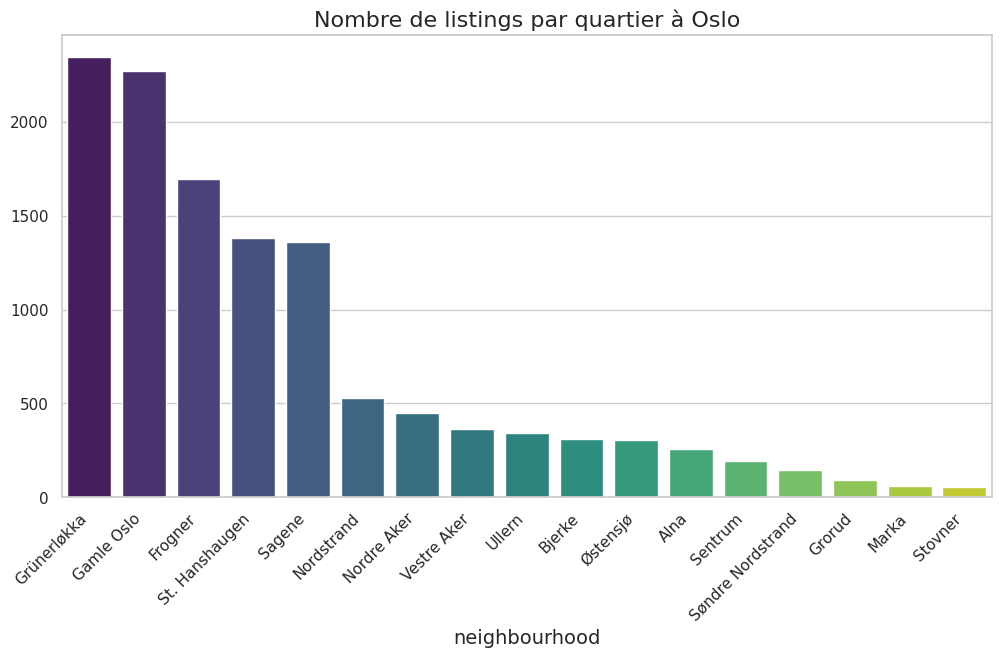

In [56]:
nb_counts = df['neighbourhood'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(
    x=nb_counts.index,
    y=nb_counts.values,
    hue=nb_counts.index,
    palette='viridis',
    legend=False
)
plt.xticks(rotation=45, ha='right')
plt.title('Nombre de listings par quartier à Oslo')
plt.show()

### 4.2. Répartition par Type de logement


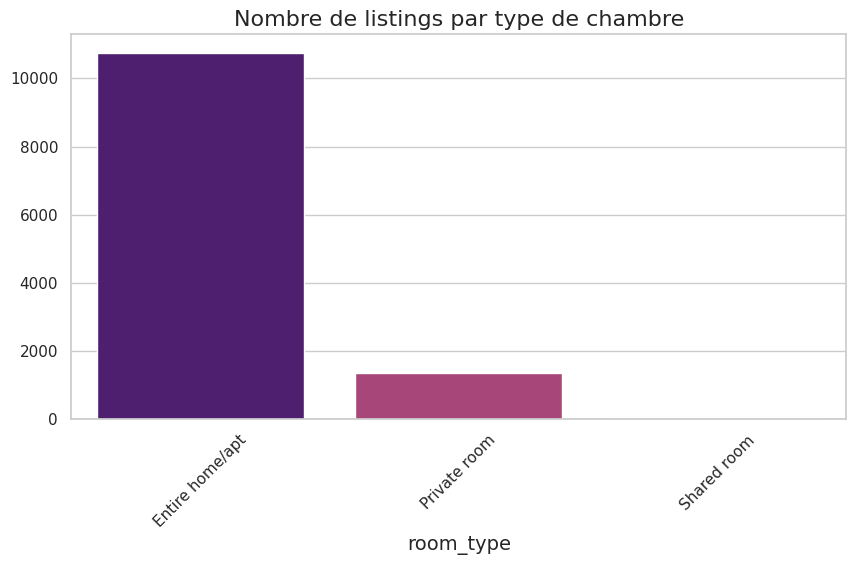

In [57]:
room_counts = df['room_type'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(
    x=room_counts.index,
    y=room_counts.values,
    hue=room_counts.index,
    palette='magma',
    legend=False
)
plt.title("Nombre de listings par type de chambre")
plt.xticks(rotation=45)
plt.show()

## 5. Analyse des prix
### 5.1. Distribution des prix et Outliers
Visualisation de la distribution brute :


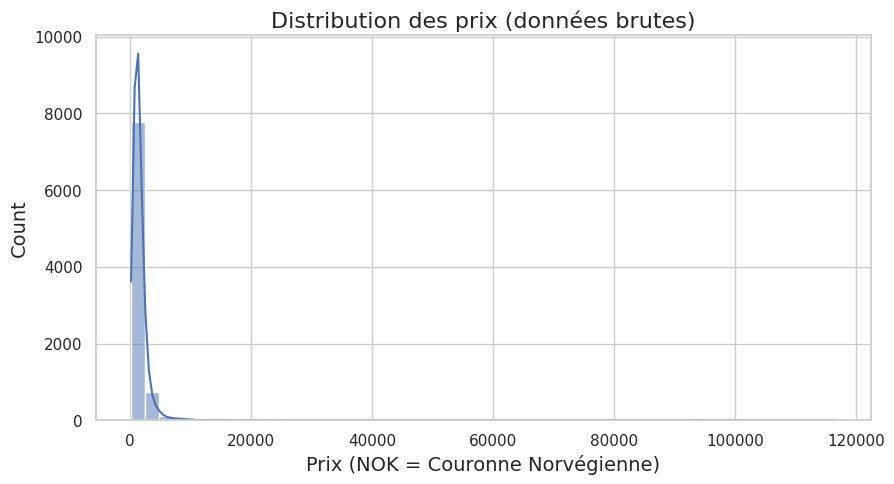

In [58]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'].dropna(), bins=50, kde=True)
plt.title('Distribution des prix (données brutes)')
plt.xlabel('Prix (NOK = Couronne Norvégienne)')
plt.show()

### 5.2. Stratégie de traitement des Outliers
- On va partir sur une suppression des **valeurs extrêmes (Top 1%)** uniquement.
- On supprime également les prix nuls ou manquants.
- Cela permet de conserver le segment Luxe légitime tout en écartant les erreurs manifestes.


In [59]:
upper_bound = df['price'].quantile(0.99)

print(f"Seuil supérieur (99%) : {upper_bound:.2f} NOK")

df_clean = df[(df['price'] > 0) & (df['price'] <= upper_bound)].copy()

deleted_count = len(df) - len(df_clean)
deleted_pct = (deleted_count / len(df)) * 100

print(f"Nombre de listings avant : {len(df)}")
print(f"Nombre de listings après filtrage : {len(df_clean)}")
print(f"Données écartées (NaN ou Outliers) : {deleted_count} ({deleted_pct:.1f}%)")

Seuil supérieur (99%) : 7198.72 NOK
Nombre de listings avant : 12160
Nombre de listings après filtrage : 8615
Données écartées (NaN ou Outliers) : 3545 (29.2%)


### 5.3. Analyse des prix sur données nettoyées


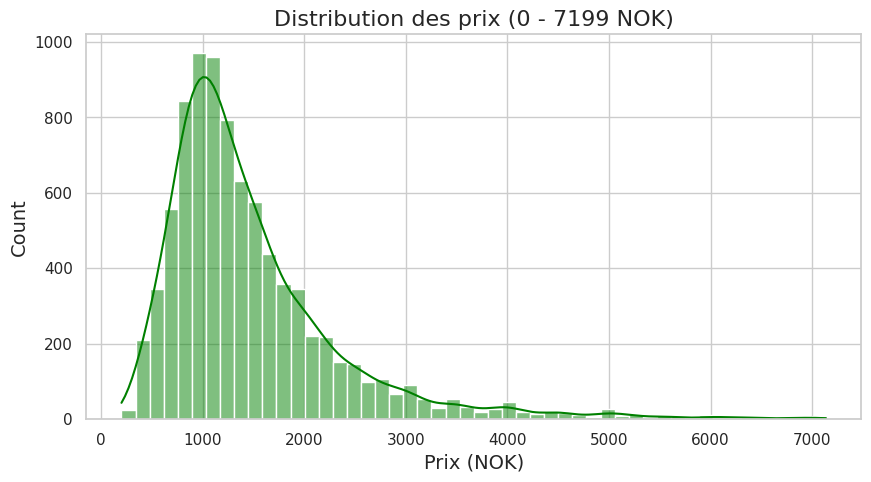

In [60]:
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['price'], bins=50, kde=True, color='green')
plt.title(f'Distribution des prix (0 - {upper_bound:.0f} NOK)')
plt.xlabel('Prix (NOK)')
plt.show()

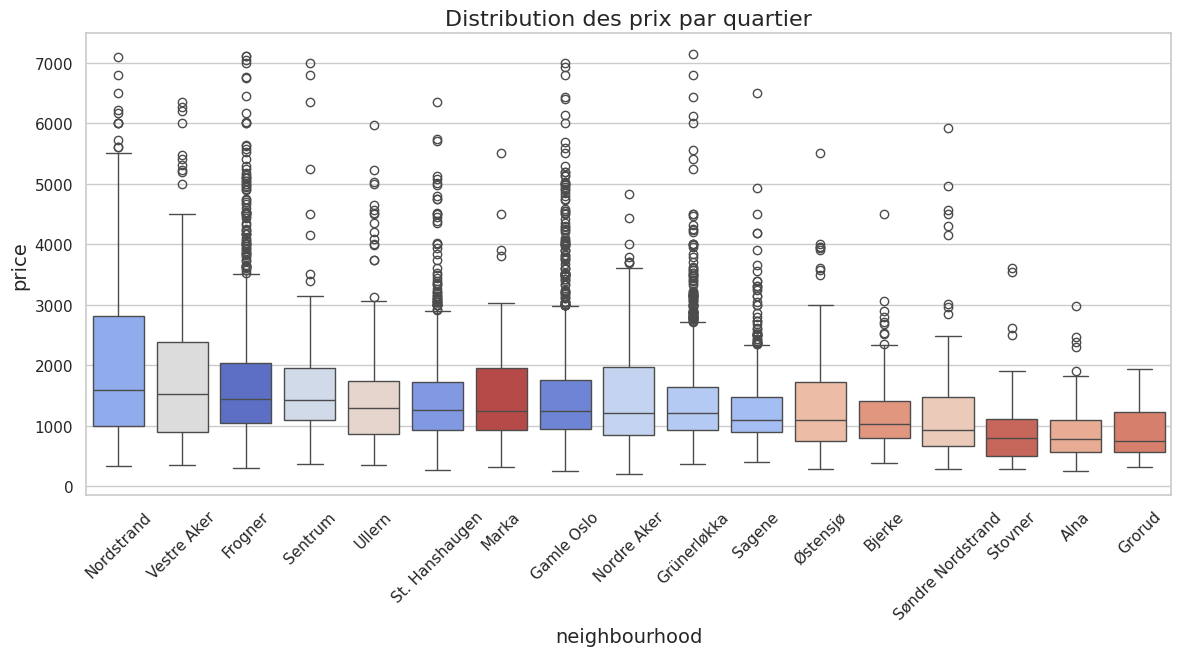

In [61]:
order_neigh = df_clean.groupby('neighbourhood')['price'].median().sort_values(ascending=False).index
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_clean,
    x='neighbourhood',
    y='price',
    order=order_neigh,
    hue='neighbourhood',
    palette='coolwarm',
    legend=False
)
plt.xticks(rotation=45)
plt.title("Distribution des prix par quartier")
plt.show()

## 6. Analyse des hôtes & des avis
### 6.1. Hôtes professionnels vs particuliers
On analyse ensuite les hôtes qui possède 3 annonces ou plus en ligne que nous considéront comme hôtes professionnels voir s'ils se comportent différemment.


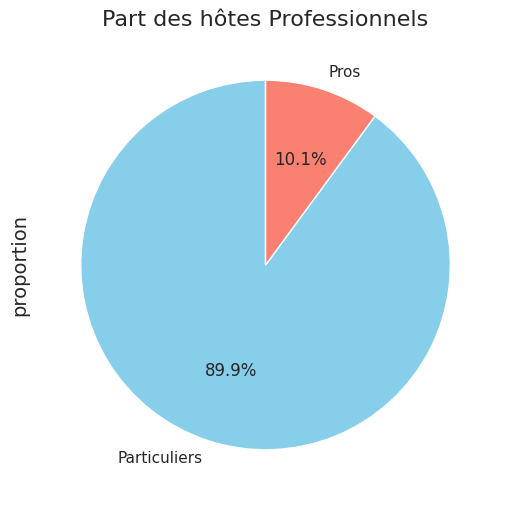

In [62]:
threshold_pro = 3
df_clean['is_pro'] = df_clean['calculated_host_listings_count'] >= threshold_pro

pro_counts = df_clean['is_pro'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 6))
pro_counts.plot.pie(autopct='%1.1f%%', labels=['Particuliers', 'Pros'], startangle=90, colors=['skyblue', 'salmon'])
plt.title('Part des hôtes Professionnels')
plt.show()

In [63]:
price_comparison = df_clean.groupby('is_pro')['price'].agg(['mean', 'median', 'count'])
price_comparison.index = ['Particulier', 'Professionnel']
print(price_comparison)

                      mean  median  count
Particulier    1490.786470  1256.0   7746
Professionnel  1387.627158  1044.0    869


> **Insights Business :**
> - **Le Paradoxe des prix :** Contrairement à l'intuition, les hôtes professionnels pratiquent des **prix moyens inférieurs** aux particuliers.
> - **Interprétation :** Les particuliers louent souvent leur résidence principale (bien équipés, grandes surfaces) pour amortir leurs charges, tandis que les professionnels optimisent le remplissage de biens plus petits et standardisés (studios, T2).


### 6.2. Impact du statut Superhost (Bonus)
Les Superhosts bénéficient-ils d'une prime de prix ?


In [64]:
if 'host_is_superhost' in df_clean.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='host_is_superhost', y='price', data=df_clean, showfliers=False, palette='Pastel1')
    plt.title('Impact du statut Superhost sur le prix')
    plt.xlabel('Superhost')
    plt.ylabel('Prix (NOK)')
    plt.show()
else:
    print("Colonne host_is_superhost non trouvée dans le dataframe nettoyé.")

Colonne host_is_superhost non trouvée dans le dataframe nettoyé.


La donnée sur les Superhosts auraient pu être intéressant à connaitre pour savoir comment orienter son offre mais n'est pas présente dans ce dataframe.

## 7. Indicateurs de demande
Le nombre d'avis est utilisé comme indicateur de volume de fréquentation.


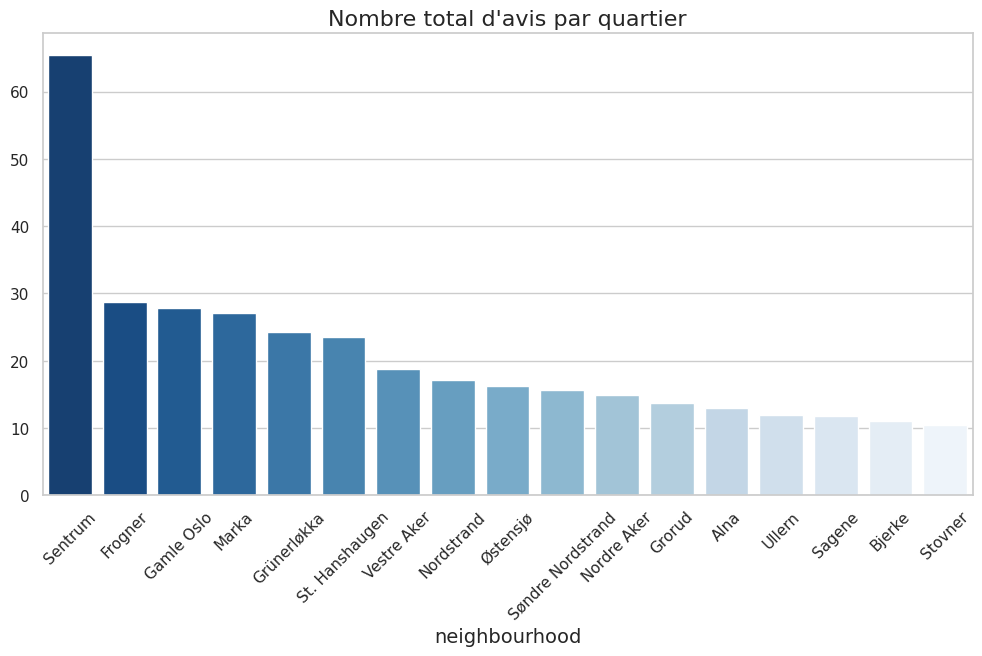

In [65]:
reviews_by_neigh = df_clean.groupby('neighbourhood')['number_of_reviews'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=reviews_by_neigh.index,
    y=reviews_by_neigh.values,
    hue=reviews_by_neigh.index,
    palette='Blues_r',
    legend=False
)
plt.xticks(rotation=45)
plt.title("Nombre total d'avis par quartier")
plt.show()

### 7.2. Performance & Revenus Estimés
On créer une matrice de corrélation de revenu pour identifier les annonces les plus performantes.


Top 15 Listings par Revenu Estimé Mensuel (Proxy) :


,name,neighbourhood,price,reviews_per_month,estimated_revenue
8640,Ekstremt sentralt - perfekt base for dine even...,Gamle Oslo,2347.0,10.32,145326.24
10298,3(4)BR Duplex Loft w/ Balcony in Central Oslo,Grünerløkka,4242.0,5.45,138713.40
11248,Leilighet på Tjuvholmen,Frogner,3356.0,6.30,126856.80
9803,Bright 3BR Funkis Apt w/ Rooftop & Workspace,St. Hanshaugen,3187.0,6.48,123910.56
8364,Waterfront/fjord view|Home office|2BR LUX,Gamle Oslo,5147.0,3.90,120439.80
1486,Oslo Korttidsleie,Gamle Oslo,5020.0,3.85,115962.00
10235,Modernt och centralt boende!,Gamle Oslo,1775.0,10.50,111825.00
3276,Double Room in Central Oslo,Sentrum,1422.0,12.82,109380.24
3277,Light and Modern Double Suite in the Heart of ...,Sentrum,1779.0,10.17,108554.58
11322,Exclusive apartment,Gamle Oslo,2583.0,6.98,108176.04


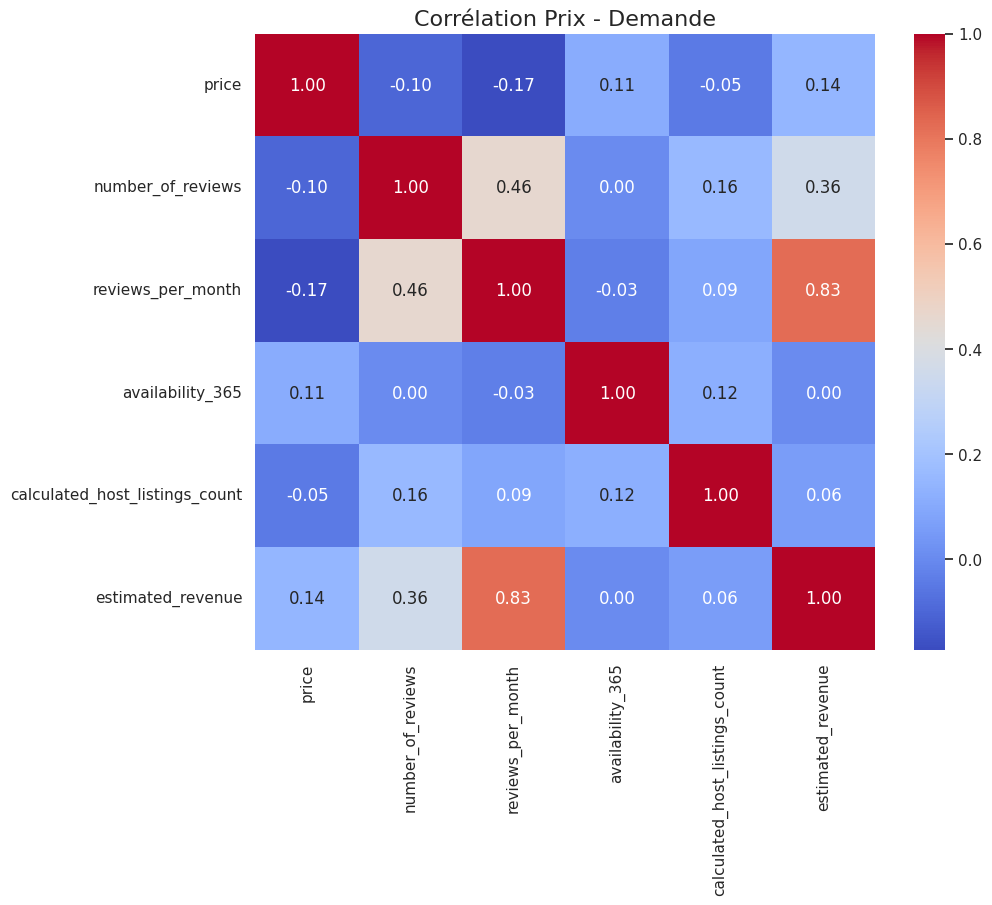

In [68]:
df_clean['estimated_revenue'] = df_clean['price'] * df_clean['reviews_per_month'].fillna(0) * 6

top_15 = df_clean[['name', 'neighbourhood', 'price', 'reviews_per_month', 'estimated_revenue']].sort_values(by='estimated_revenue', ascending=False).head(15)
print('Top 15 Listings par Revenu Estimé Mensuel (Proxy) :')
display(top_15)

plt.figure(figsize=(10, 8))
cols_corr = ['price', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'calculated_host_listings_count', 'estimated_revenue']
sns.heatmap(df_clean[cols_corr].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corrélation Prix - Demande')
plt.show()

On peut donc voir ce qui est le plus corrélé en regardant ce qui tend le plus vers 1. On voit ainsi que le revenu estimé est fortement corrélé au nombre de revue par mois mais que sinon les autres paramètres sont très peu corrélé entre eux.

## 8. Segmentation (Budget / Mid / Luxe)
Segmentation basée sur les terciles du marché nettoyé.


In [72]:
p33 = df_clean['price'].quantile(0.33)
p66 = df_clean['price'].quantile(0.66)

def segment_price(price):
    if price < p33: return 'Budget'
    elif price < p66: return 'Mid-Range'
    else: return 'Premium'

df_clean['segment'] = df_clean['price'].apply(segment_price)

print(f"Seuils de segmentation :")
print(f"- Budget (<{p33:.0f} NOK)")
print(f"- Premium (>{p66:.0f} NOK)")

Seuils de segmentation :
- Budget (<1015 NOK)
- Premium (>1530 NOK)


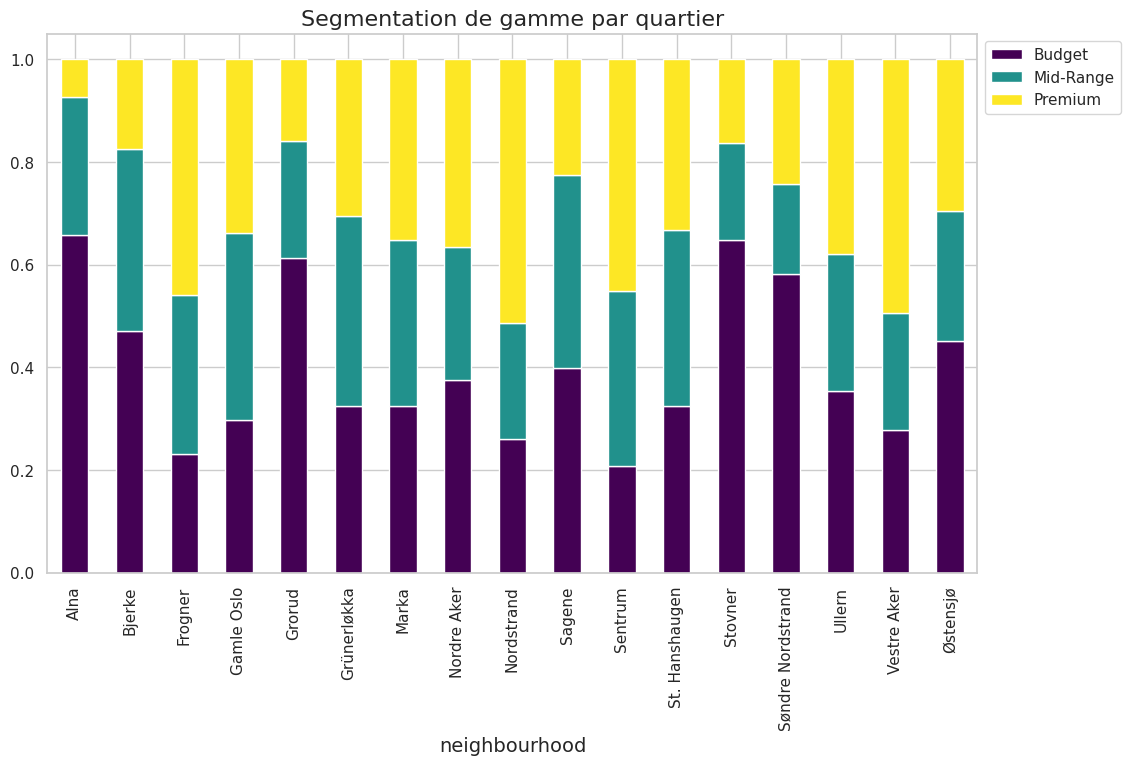

In [73]:
ct = pd.crosstab(df_clean['neighbourhood'], df_clean['segment'])
ct_norm = ct.div(ct.sum(1), axis=0)

ct_norm.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Segmentation de gamme par quartier')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

On voit ainsi que les quartiers centre ville propose beaucoup de premium, ce qui correspondrait plutôt à la hausse des prix du à l'attractivité et non à la gamme premium contrairement aux quartiers excentré en dehors de la couronne urbaine de Oslo qui ne comporte que peu de premium qui correspondrait plutôt à la baisse des prix cohérentes de logement en périphérie.

## 9. Synthèse business & limites

### 9.1. Insights Validés
1. **Marché** : Une offre concentrée sur le centre-ville et l'ouest d'Oslo.
2. **Prix** : Le centre (Frogner) reste le plus cher, mais des quartiers comme Grünerløkka sont très dynamiques.
3. **Professionnels** : Ils représentent une part significative de l'offre mais proposent des biens en moyenne moins chers (standardisation), laissant le segment "Luxe/Authentique" aux particuliers.

### 9.2. Limites corrigées
- **Données manquantes** : ~30% des prix étaient manquants dans le jeu de données initial, ce qui réduit la base d'analyse.
- **Saisonnalité** : Données snapshot ne reflétant pas les variations été/hiver.
